In [516]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [517]:
import h5py

In [518]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [519]:
from uatu.scattering import *
from kymatio import Scattering2D

In [520]:
from scipy import fftpack
from scipy.ndimage import gaussian_filter
import numpy as np
import pylab as py
#import radialProfile
from scipy.fftpack import fft2

In [521]:
model_path = '/home/sean/Git/uatu/networks/resnet_max_mode_0_J_0_epoch_00.pth'

In [522]:
#mode = 2
mode = 0
#max_order = 2
max_order = 0

#J = 2
J = 0
L = 8
K = int(1 + L*J +(L**2)*(J*(J-1))/2.0)

width = 2
shape = (256, 256)

In [523]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [524]:
scattering = lambda x: x
#scattering = lambda x: gaussian_filter(x, 1)

In [525]:
model = Scattering2dResNet(K, J, k=width).to(device)

In [526]:
model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

In [527]:
model.eval()

Scattering2dResNet(
  (init_conv): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (layer_0): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [528]:
def log_barrier(x_p, x_o, eps=2., lam=1e6):
    # TODO, in pytorch
    norm = (x_p - x_o).norm(p=float('Inf')) + 1e-6

    assert norm < eps
    return -torch.log(eps - norm )/lam

In [529]:
def get_embedding(x, model):
    x = scattering(x)

    x = x.view(1, model.K, model.input_size, model.input_size)#

############# UNCOMMENT ME ################
    x = model.init_conv(x)
    
    for i,l in enumerate(model.layers):
        #if i ==1:
        #    break
        x = l(x)
    return model.avgpool(x)

In [530]:
def fgsm_attack(image, eps, data_grad):
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - eps*sign_data_grad
    #perturbed_image = image - eps*data_grad/(data_grad.sum()/(256))

    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [531]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    #print(deltar.shape)
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [532]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=4*deg)
    _, psd1D = cmap.powerSpectrum(l)
    '''
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)
    '''
    return psd1D#/psd1D[0]

In [533]:
def plot_ps(X_orig, X_target, X_attack):
    
    X_orig = X_orig.data.to('cpu').numpy()
    X_target = X_target.data.to('cpu').numpy()
    X_attack = X_attack.data.to('cpu').numpy()

    attacked_ps = image_ps(X_attack.squeeze())
    target_ps = image_ps(X_target.squeeze())
    normal_ps = image_ps(X_orig.squeeze())
    diff_ps = image_ps((X_attack.squeeze()- X.squeeze()).squeeze())
    
    #fig = plt.figure(figsize = (8, 12))
    #plt.subplot(211)
    plt.plot(attacked_ps, label = 'Attacked' )
    plt.plot(target_ps, label = 'Target')
    plt.plot(normal_ps, label = 'Original')
    #plt.plot(diff_ps, label = 'Diff')

    plt.legend(loc='best')
    plt.loglog();
    #plt.subplot(212)
    #plt.title("Attacked/Normal")
    #plt.plot(attacked_ps/normal_ps, label = 'Attacked')
    #plt.plot(target_ps/normal_ps, label = 'Target')
    #plt.legend(loc='best')
    #plt.ylim([0.4, 6])
    #plt.loglog();
    plt.show();

In [534]:
def compute_robust_map(model, x0, xt): #use_log_barrier = True, log_eps = 1.5)

    # Send the data and label to the device
    x0, xt = x0.to(device), xt.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    perturbed_x0 = x0.clone()

    perturbed_x0.requires_grad = True
    scattering.requires_grad = False
    # Forward pass the data through the model
    init_pred = get_embedding(xt, model)
    #init_fft = 2*torch.log(torch.abs(torch.rfft(xt.squeeze(), 2)))
    # Calculate the 6oss
    epsilon =1e-3

    for i in range(500):
        output = get_embedding(perturbed_x0, model)
        # TODO put power spectrum here too? 
        loss = (output-init_pred).norm() + log_barrier(perturbed_x0, x0) #+ (init_fft - torch.log(torch.abs(torch.rfft(perturbed_x0.squeeze(), 2)))).norm() #- log_barrier(perturbed_x0, xt)
        #print( (output-init_pred).norm(), log_barrier(perturbed_x0, xt))
        print(loss)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward(retain_graph = True)

        # Collect datagrad

        x0_grad = perturbed_x0.grad.data
        # Call FGSM Attack
        if i%100 == 0:
            print('*'*20, i, '*'*20)
            epsilon= epsilon*0.9
            print('e', epsilon)
            plot_ps(x0, xt, perturbed_x0)
            plt.imshow(perturbed_x0.data.to('cpu').numpy().squeeze())
            plt.show();
            
        perturbed_x0 = fgsm_attack(perturbed_x0, epsilon, x0_grad)
        
        perturbed_x0 = torch.autograd.Variable(perturbed_x0.data, requires_grad=True)

    return perturbed_x0, init_pred, output

In [535]:
def count_peaks(im, size = 1):
    # i don't know if there's a faster way to do this but alas
    peak_idxs = np.zeros_like(im, dtype = bool)
    for i in range(size, im.shape[0]-size):
        for j in range(size, im.shape[1]-size): # no peaks on the boundaries i declare
            block = im[i-size:i+size+1, j-size:j+size+1].flatten()
            if np.all(im[i,j] >= block):
                peak_idxs[i,j] = True
    return im[peak_idxs]

In [536]:
f = h5py.File('../data/UatuLightconeTraining.hdf5', 'r')
mean, std =  f.attrs['mean'], f.attrs['std']
f.close()

In [537]:
f = h5py.File('../data/UatuLightconeSameSeed.hdf5', 'r')
#for boxno in xrange(5):
boxno = 2
target_boxno = 3
test_X = np.array(f['Box%03d'%boxno]["X"][()])
test_Y = f['Box%03d'%boxno]['Y'][0].reshape((1,2))

target_X = np.array(f['Box%03d'%target_boxno]["X"][()])
target_Y = f['Box%03d'%target_boxno]['Y'][0].reshape((1,2))
f.close()

In [538]:
test_X = (test_X-mean)/(std)
target_X = (target_X-mean)/(std)

In [539]:
n_orig = 201#100 
n_targ = n_orig#201
batch_size = 1 

X = test_X[n_orig, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
X = np.tile(X, (batch_size, 1, 1, 1) )
Y = test_Y[0, :].reshape((1, test_Y.shape[1]))
Y = np.tile(Y, (batch_size, 1))

In [540]:
np.random.seed(64)
X = np.random.randn(*X.shape)#*X.std() + X.mean()

In [541]:
targ_X = target_X[n_targ, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
#targ_X = (targ_X-mean)/(std)

In [542]:
from astropy.units import deg

from lenstools import GaussianNoiseGenerator, ConvergenceMap

#Set map side angle, and number of pixels on a side
num_pixel_side = shape[0]
side_angle = 4 * deg

#Read the power spectrum (l,Pl) from an external file, and load it in numpy array format (the generator interpolates the power spectrum between bins)
Pl = image_ps(targ_X.squeeze())

In [543]:
#90% sure this is right
l = np.linspace(128, 128*128, Pl.shape[0]+1)

In [544]:
cmap = ConvergenceMap(targ_X.squeeze(), angle=side_angle)
l2, Pl2 = cmap.powerSpectrum(l)

In [545]:
X = (X- X.mean())/(X.std())*targ_X.std()+targ_X.mean()

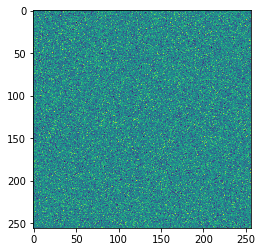

In [546]:
plt.imshow(X.squeeze())

tensor(28.0441, device='cuda:0', grad_fn=<AddBackward0>)
******************** 0 ********************
e 0.0009000000000000001


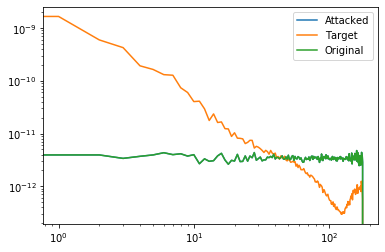

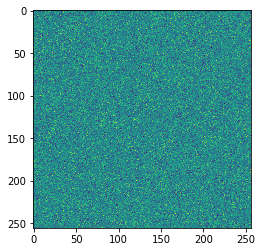

tensor(14.7541, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.7833, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.7867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.7849, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.8087, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.0422, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.6043, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9456, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.5362, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4967, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.8737, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4687, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.8567, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4494, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.8436, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4374, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.8336, device='cuda:0', grad_fn=<AddBa

In [ ]:
X_robust, init_embed, robust_embed = compute_robust_map(model,\
                                  torch.Tensor(X).reshape((1, shape[0], shape[1])), \
                                torch.Tensor(gaussian_filter(targ_X,0)).reshape((1, shape[0], shape[1])) )#,\

In [ ]:
X_robust = X_robust.to('cpu').detach().numpy().squeeze()
init_embed = init_embed.to('cpu').detach().numpy().squeeze()
robust_embed = robust_embed.to('cpu').detach().numpy().squeeze()

In [ ]:
init_embed.shape

In [ ]:
def get_embedding_2(x, model):
    x = scattering(x)

    x = x.view(1, model.K, model.input_size, model.input_size)#
############# UNCOMMENT ME ################
    x = model.init_conv(x)

    for i,l in enumerate(model.layers):
        #if i ==1:
        #    break
        x = l(x)
    
    return x

In [ ]:
activ_X = get_embedding_2(torch.Tensor(gaussian_filter(targ_X, 0)).to('cuda'), model).to('cpu')#.detach().numpy().squeeze()
embed_X = model.avgpool(activ_X).detach().numpy().squeeze()
activ_X = activ_X.detach().numpy().squeeze()

In [ ]:
activ_X_rob = get_embedding_2(torch.Tensor(X_robust).to('cuda'), model).to('cpu')#.detach().numpy().squeeze()
embed_X_rob = model.avgpool(activ_X_rob).detach().numpy().squeeze()
activ_X_rob = activ_X_rob.detach().numpy().squeeze()

In [ ]:
print(np.linalg.norm(init_embed-robust_embed))

In [ ]:
X_robust.max(), X.max()

In [ ]:
vmin = min(X.min(), targ_X.min())
vmax = max(X.max(), targ_X.max())

In [ ]:
im = plt.imshow(X_robust.squeeze(), vmin = vmin, vmax = vmax)
plt.colorbar(im)

In [ ]:
im = plt.imshow(targ_X.squeeze(),vmin = vmin, vmax = vmax)
plt.colorbar(im)

In [ ]:
im = plt.imshow(gaussian_filter(targ_X.squeeze(), 3),vmin = vmin, vmax = vmax)
plt.colorbar(im)

In [ ]:
im = plt.imshow(X.squeeze(), vmin = vmin, vmax = vmax)
plt.colorbar(im)

In [ ]:
plt.imshow((-X.squeeze() + X_robust.squeeze()))#, vmin = vmin, vmax = vmax)

In [ ]:
plt.imshow((-targ_X.squeeze() + X_robust.squeeze()))#,vmin = vmin, vmax = vmax)

In [ ]:
model(scattering(torch.Tensor(X.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

In [ ]:
model(scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

In [ ]:
orig_s = scattering(torch.Tensor(X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
robust_s = scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
targ_s = scattering(torch.Tensor(targ_X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()

In [ ]:
np.linalg.norm(orig_s-targ_s), np.linalg.norm(robust_s-targ_s)

In [ ]:
fig = plt.figure(figsize = (12,4))
plt.subplot(131)
plt.title('Orig Image')
plt.imshow(X.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(132)
plt.title('Perturbed Image')
plt.imshow(X_robust.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(133)
plt.title('Target Image')
plt.imshow(targ_X.squeeze(), vmin = vmin, vmax= vmax)

In [ ]:
size = 1
orig_peaks = count_peaks(X.squeeze(), size = size)
print(orig_peaks.shape)
sns.distplot(orig_peaks,label = 'X');
targ_peaks = count_peaks(targ_X.squeeze(), size = size)
print(targ_peaks.shape)
sns.distplot(targ_peaks,label = "targ_X")
rob_peaks = count_peaks(X_robust.squeeze(), size = size)
print(rob_peaks.shape)
sns.distplot(rob_peaks,label = 'rob_X')
plt.legend(loc = 'best');

In [ ]:
sns.distplot(X.flatten(), label = 'X')
sns.distplot(targ_X.flatten(), label = 'targ_X')
sns.distplot(X_robust.flatten(), label = 'rob_X')
plt.legend(loc='best')

---

In [ ]:
attacked_ps = image_ps(X_robust.squeeze())
target_ps = image_ps(targ_X.squeeze())
normal_ps = image_ps(X.squeeze())
diff_ps = image_ps((X_robust- X.squeeze()).squeeze())

In [ ]:
fig = plt.figure(figsize = (8, 6))
#plt.subplot(211)
plt.plot(attacked_ps, label = 'Attacked' )
plt.plot(target_ps, label = 'Target')
plt.plot(normal_ps, label = 'Original')
#plt.plot(diff_ps, label = 'Diff')

plt.legend(loc='best')
plt.loglog();
#plt.subplot(212)
#plt.title("Attacked/Normal")
#plt.plot(attacked_ps/normal_ps, label = 'Attacked')
#plt.plot(target_ps/normal_ps, label = 'Target')
#plt.legend(loc='best')
#plt.ylim([0.4, 6])
#plt.loglog();

In [ ]:
fig = plt.figure(figsize = (8, 6))
#plt.subplot(211)
plt.plot(attacked_ps, label = 'Attacked' )
plt.plot(target_ps, label = 'Target')
plt.plot(normal_ps, label = 'Original')
#plt.plot(diff_ps, label = 'Diff')

plt.legend(loc='best')
plt.loglog();
plt.title('Smoothed')
plt.ylim([1e-13, 1e-8])
#plt.subplot(212)
#plt.title("Attacked/Normal")
#plt.plot(attacked_ps/normal_ps, label = 'Attacked')
#plt.plot(target_ps/normal_ps, label = 'Target')
#plt.legend(loc='best')
#plt.ylim([0.4, 6])
#plt.loglog();